In [99]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 
import scanpy as sc
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import DistanceMetric
from kneed import KneeLocator as kl


sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

#directory for graphs
large_root = "/Users/devpatelio/Downloads/Coding/Computational_Biology/SingleCell-RNAseq/filtered_gene_bc_matrices/hg19"
results_file = large_root+'/pbmc3k.h5ad'

#load data
adata = sc.read_10x_mtx(large_root, var_names = 'gene_symbols', cache=True)

... reading from cache file cache/Users-devpatelio-Downloads-Coding-Computational_Biology-SingleCell-RNAseq-filtered_gene_bc_matrices-hg19-matrix.h5ad


normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'


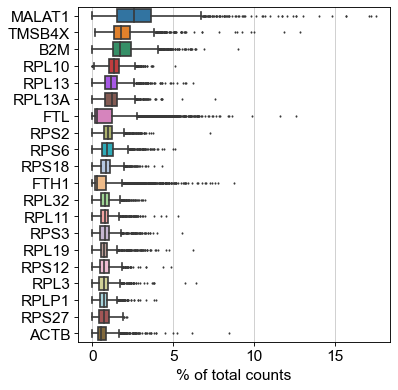

In [26]:
print(adata)
sc.pl.highest_expr_genes(adata, n_top=20)

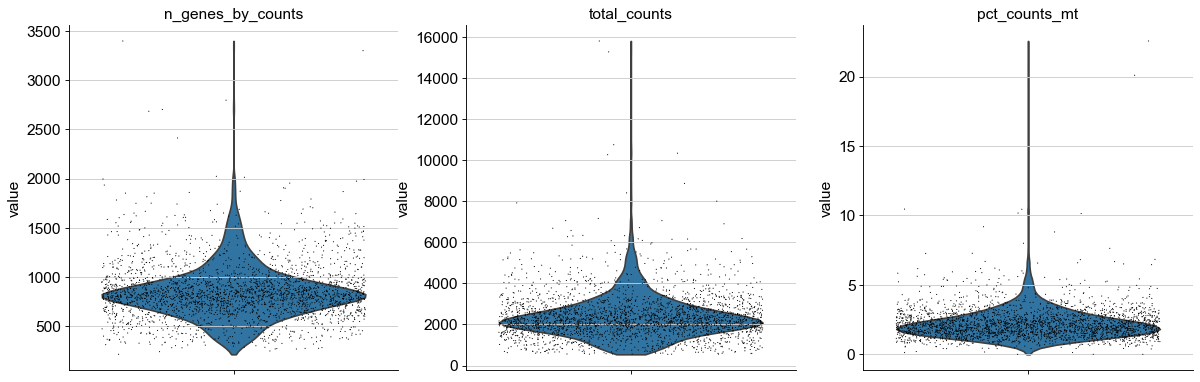

/Users/devpatelio/miniconda3/envs/sc-rnaseq/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/devpatelio/miniconda3/envs/sc-rnaseq/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/devpatelio/miniconda3/envs/sc-rnaseq/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

<AxesSubplot:xlabel='pct_counts_mt', ylabel='Density'>

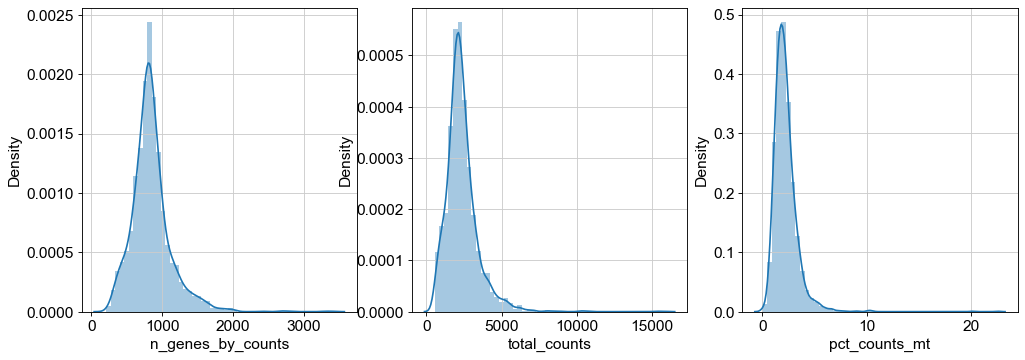

In [73]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

QC_data = adata.copy()

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.distplot(adata.obs['n_genes_by_counts'], ax=axes[0])
sns.distplot(adata.obs['total_counts'], ax=axes[1])
sns.distplot(adata.obs['pct_counts_mt'], ax=axes[2])

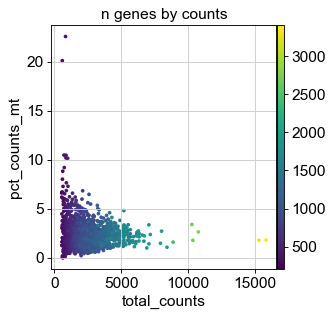

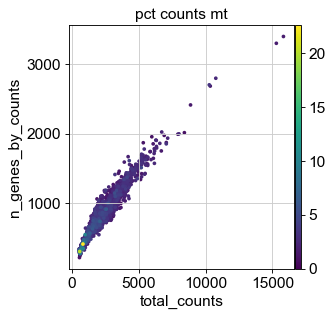

In [71]:
# fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color='n_genes_by_counts')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt')

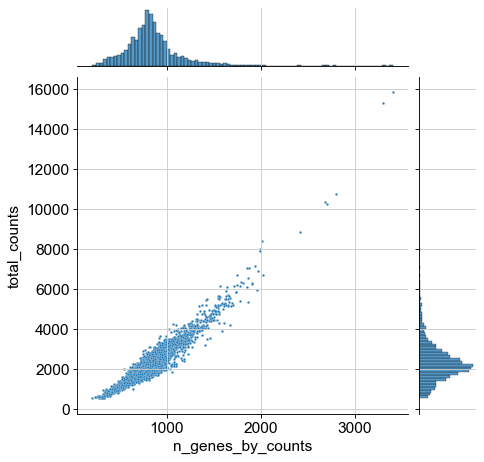

In [72]:
# ax = plt.gca()
# plt.savefig(large_root+"/"+'QCbefore.png')
sns.jointplot(
    x="n_genes_by_counts",
    y="total_counts",
    data = adata.obs,
    kind="scatter",
    s=5
)

In [75]:
sc.pp.filter_cells(QC_data, min_genes=200)
sc.pp.filter_genes(QC_data, min_cells=3)

In [76]:
QC_data = QC_data[QC_data.obs.n_genes_by_counts < 2200, :]
QC_data = QC_data[QC_data.obs.pct_counts_mt < 5, :]

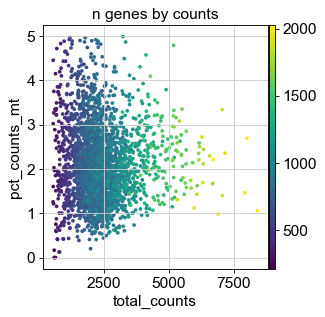

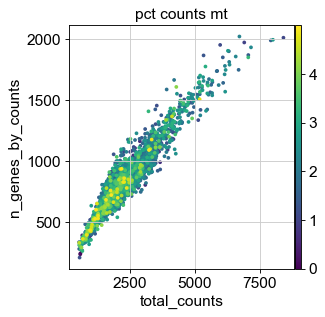

In [77]:
sc.pl.scatter(QC_data, x='total_counts', y='pct_counts_mt', color='n_genes_by_counts')
sc.pl.scatter(QC_data, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt')

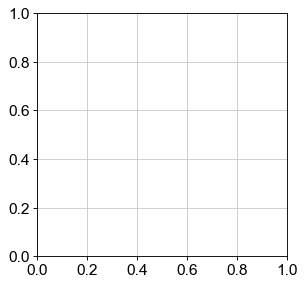

In [69]:
ax = plt.gca()
plt.savefig(large_root + '/' + 'QCraft.png')

In [78]:
norm_data = QC_data.copy()
sc.pp.normalize_total(norm_data, target_sum=1e4)
sc.pp.log1p(norm_data)

normalizing counts per cell
    finished (0:00:00)


extracting highly variable genes
    finished (0:00:00)


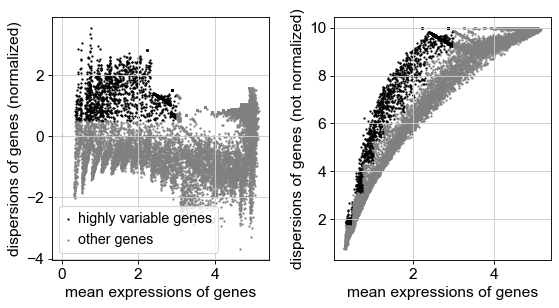

In [151]:
a = sc.pp.highly_variable_genes(norm_data, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(norm_data)

In [81]:
HVG_data = norm_data.copy()
HVG_data.raw = HVG_data
HVG_data = HVG_data[:, HVG_data.var.highly_variable]


In [82]:
pcHVG_data = HVG_data.copy()
sc.pp.scale(pcHVG_data, max_value=10)
sc.tl.pca(pcHVG_data, svd_solver='arpack')

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


AnnData object with n_obs × n_vars = 2637 × 1834
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'


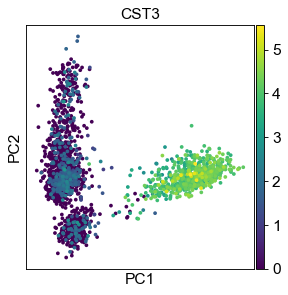

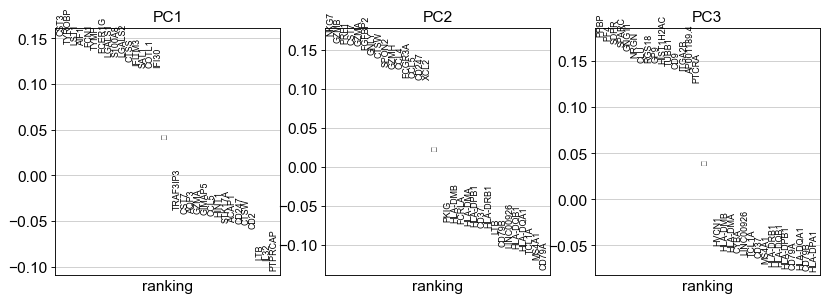

In [85]:
pcHVG_data.write(results_file)
print(pcHVG_data)
sc.pl.pca(pcHVG_data, color='CST3')
sc.pl.pca_loadings(pcHVG_data)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


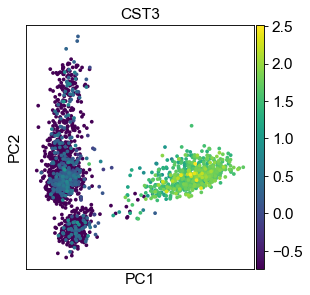

/Users/devpatelio/miniconda3/envs/sc-rnaseq/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/devpatelio/miniconda3/envs/sc-rnaseq/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


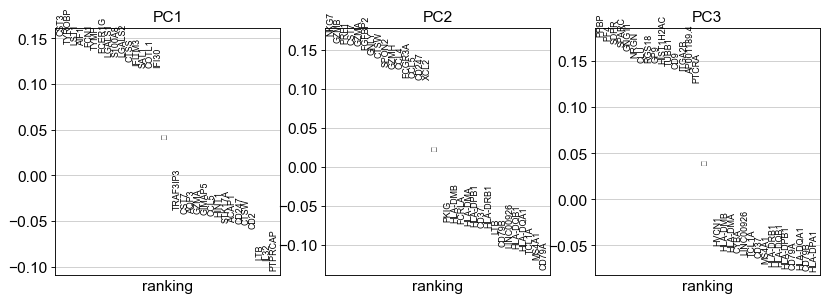

In [87]:
sc.pp.scale(norm_data, max_value=10)
sc.tl.pca(norm_data, svd_solver='arpack')
sc.pl.pca(norm_data, color='CST3')
sc.pl.pca_loadings(norm_data)

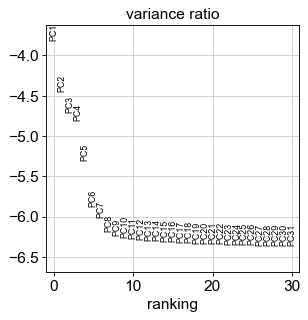

In [102]:
sc.pl.pca_variance_ratio(pcHVG_data, log=True)

def PCA_Elbow_fit(data):
    model = sklearn.decomposition.PCA()
    model.fit(data)
    explained_variance = model.explained_variance_ratio_
    pcs = list(range(1, explained_variance.shape[0]+1))
    klm = kl(pcs, explained_variance, S=1.0, curve='convex', direction='decreasing')
    pcs_used = klm.knee
    pc_list = list(range(1, pcs_used+1))
    new_data = sklearn.decomposition.PCA(n_components=pcs_used, svd_solver='arpack').fit_transform(data)
    return pcs_used, new_data, pcs, explained_variance, pc_list

label = "HVG_data"
new_frame = pd.DataFrame(HVG_data.X.toarray(), index=HVG_data.obs_names, columns=HVG_data.var_names)
pandas_data = new_frame.values


In [104]:
dim, new_matrix, pc_ax, pc_ay, col_labels = PCA_Elbow_fit(pandas_data)
print(dim)


14


In [106]:
columns = ['PC_' + str(i) for i in col_labels]
output_path = large_root + '_PCA_' + label + str(dim) + '.csv'
PC_frame = pd.DataFrame(new_matrix, index=new_frame.index.values.tolist(), columns=columns)
print(PC_frame.head())
print(PC_frame.shape)

                       PC_1      PC_2      PC_3      PC_4      PC_5      PC_6  \
AAACATACAACCAC-1  -4.430910  0.262369 -1.492730 -0.000804  1.078562 -0.375001   
AAACATTGAGCTAC-1  -0.755941 -4.268149  6.053715 -1.799754  1.351323 -0.325755   
AAACATTGATCAGC-1  -2.829492  1.411133 -2.966496 -3.689729  0.793966  0.845251   
AAACCGTGCTTCCG-1  11.279482  0.626299  1.217365 -0.591569  0.853541  0.988310   
AAACCGTGTATGCG-1  -2.076110  7.286497  4.471401  5.061386 -3.542386  2.395826   

                      PC_7      PC_8      PC_9     PC_10     PC_11     PC_12  \
AAACATACAACCAC-1 -1.079321 -0.939441  3.131510  1.103082 -1.175617  0.598462   
AAACATTGAGCTAC-1  0.382618  0.423996  1.114891 -1.492343 -0.674553 -1.428775   
AAACATTGATCAGC-1  1.916349  0.943599 -1.158316 -1.200846  0.580050  0.251147   
AAACCGTGCTTCCG-1 -0.645886 -0.354307 -0.949230  0.301244 -0.234246  0.248416   
AAACCGTGTATGCG-1  0.718490 -0.703588 -2.091881  1.734316  1.409964  0.914319   

                     PC_13     P

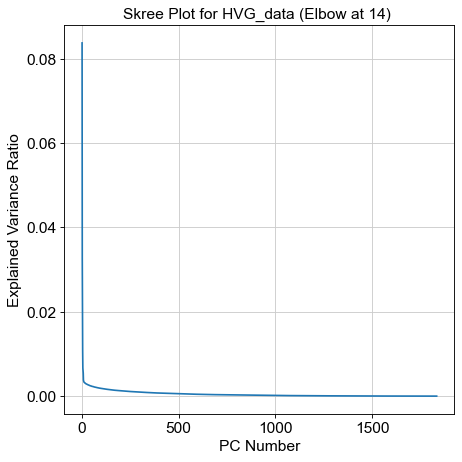

In [109]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)
ax1.set_title("Skree Plot for "+label+" (Elbow at "+str(dim)+") ")
ax1.plot(pc_ax, pc_ay)
ax1.set_xlabel("PC Number")
ax1.set_ylabel("Explained Variance Ratio")
fig.tight_layout()
# plt.savefig(large_root+'/_PCA_'+str(dim)+'.png')
# fig.clear()

computing neighbors
    using 'X_pca' with n_pcs = 14
    finished (0:00:00)
computing UMAP
    finished (0:00:02)


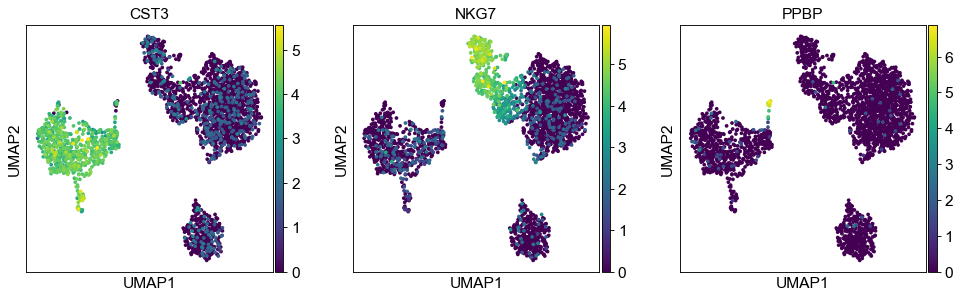

computing tSNE
    using 'X_pca' with n_pcs = 14
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:17)


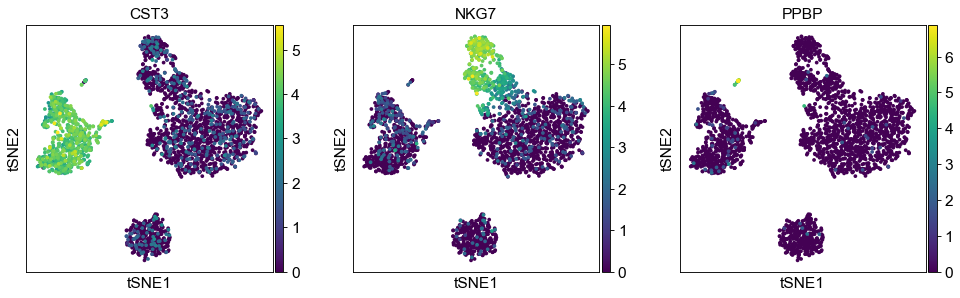

computing neighbors
    using 'X_pca' with n_pcs = 14
    finished (0:00:00)
computing UMAP
    finished (0:00:03)


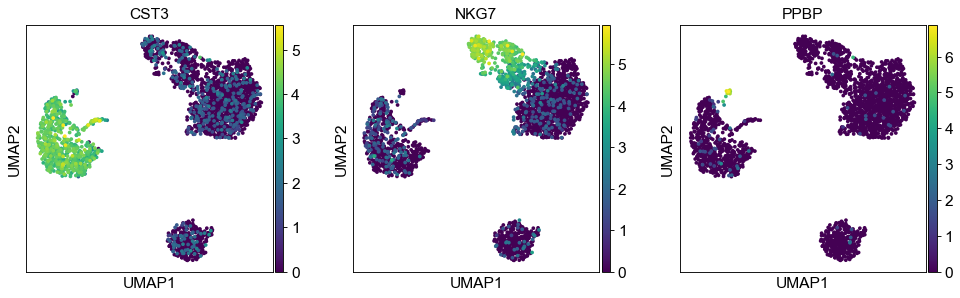

computing tSNE
    using 'X_pca' with n_pcs = 14
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:18)


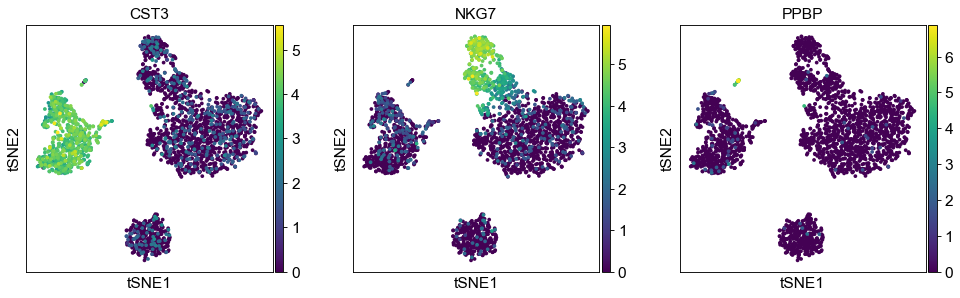

computing neighbors
    using 'X_pca' with n_pcs = 14
    finished (0:00:00)
computing UMAP
    finished (0:00:04)


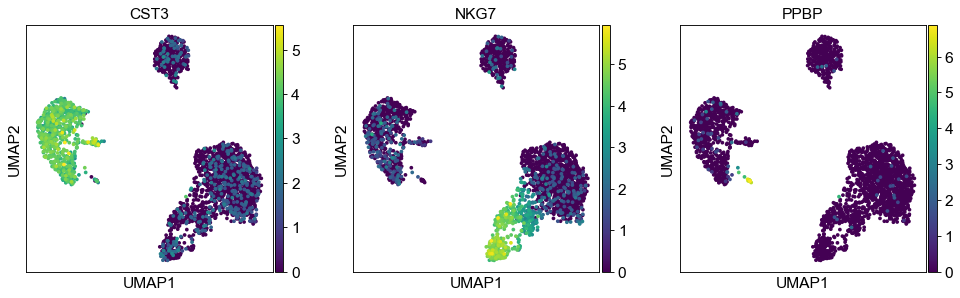

computing tSNE
    using 'X_pca' with n_pcs = 14
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:15)


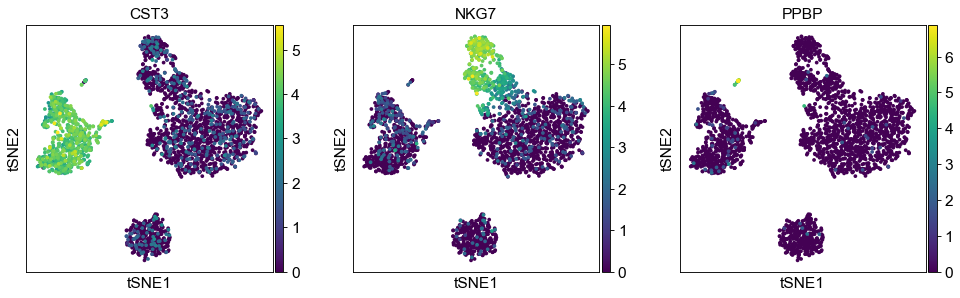

In [160]:
sc.pp.neighbors(pcHVG_data, n_neighbors=5, n_pcs=dim)
sc.tl.umap(pcHVG_data)
sc.pl.umap(pcHVG_data, color=['CST3', 'NKG7', 'PPBP'])
sc.tl.tsne(pcHVG_data, n_pcs=dim)
sc.pl.tsne(pcHVG_data, color=['CST3', 'NKG7', 'PPBP'])

sc.pp.neighbors(pcHVG_data, n_neighbors=10, n_pcs=dim)
sc.tl.umap(pcHVG_data)
sc.pl.umap(pcHVG_data, color=['CST3', 'NKG7', 'PPBP'])
sc.tl.tsne(pcHVG_data, n_pcs=dim)
sc.pl.tsne(pcHVG_data, color=['CST3', 'NKG7', 'PPBP'])

sc.pp.neighbors(pcHVG_data, n_neighbors=20, n_pcs=dim)
sc.tl.umap(pcHVG_data)
sc.pl.umap(pcHVG_data, color=['CST3', 'NKG7', 'PPBP'])
sc.tl.tsne(pcHVG_data, n_pcs=dim)
sc.pl.tsne(pcHVG_data, color=['CST3', 'NKG7', 'PPBP'])

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


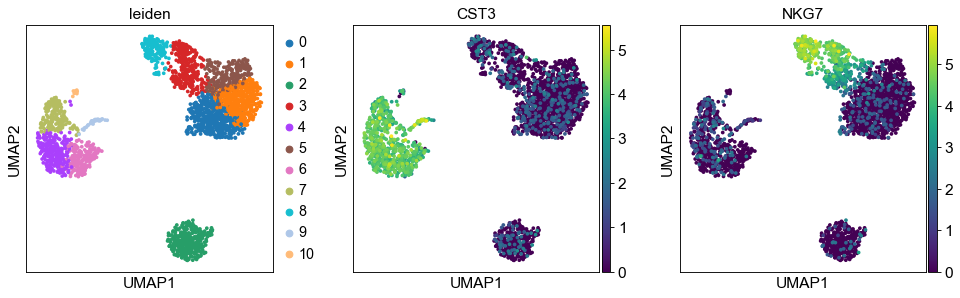

In [115]:
sc.tl.leiden(pcHVG_data, resolution = 1)
sc.pl.umap(pcHVG_data, color=['leiden', 'CST3', 'NKG7'])
pcHVG_data.write(results_file)


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


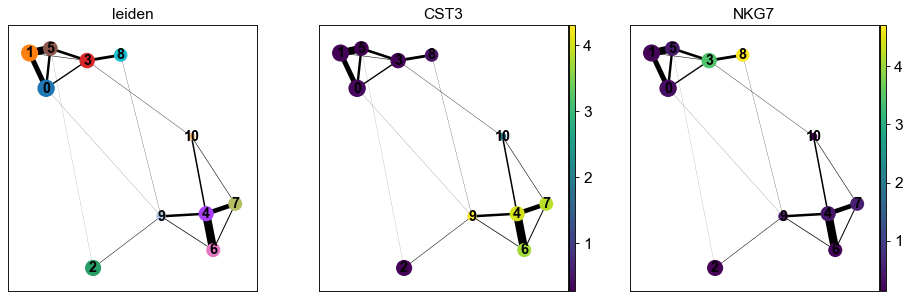

In [117]:
sc.tl.paga(pcHVG_data, groups='leiden')
sc.pl.paga(pcHVG_data, color=['leiden', 'CST3', 'NKG7'])

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:14)


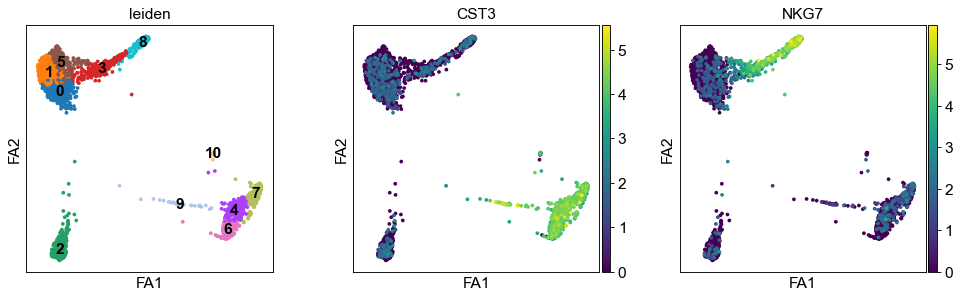

In [118]:
sc.tl.draw_graph(pcHVG_data, init_pos='paga')
sc.pl.draw_graph(pcHVG_data, color=['leiden', 'CST3', 'NKG7'], legend_loc='on data')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


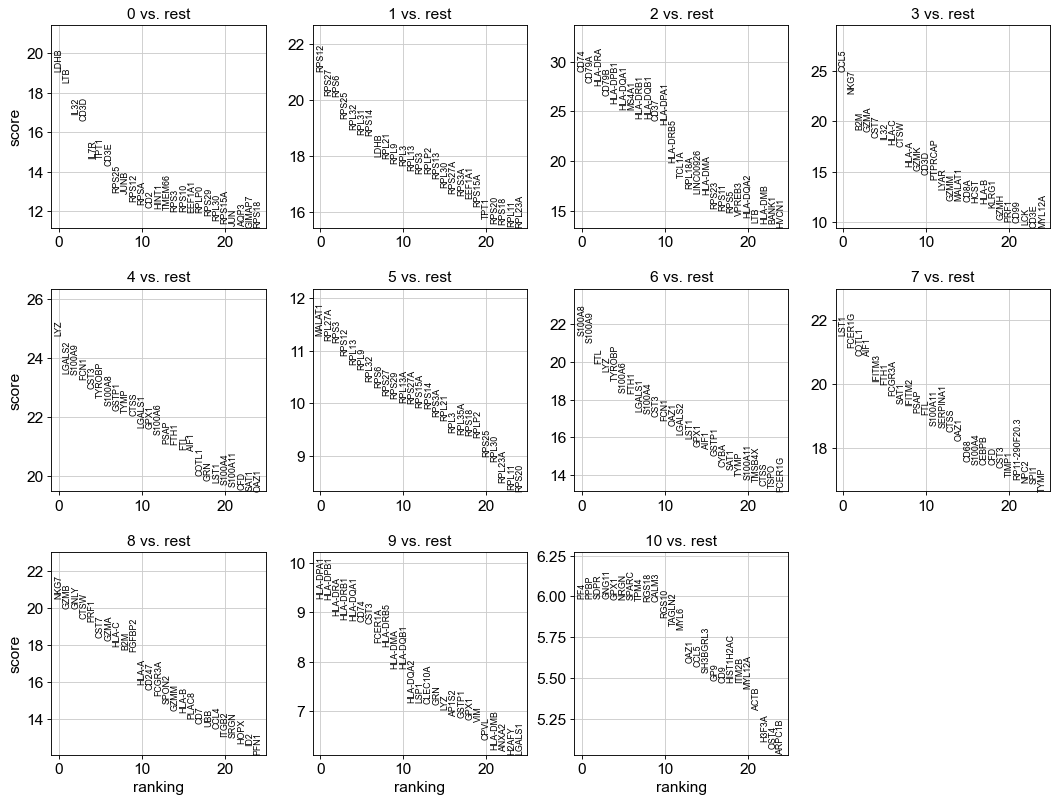

In [119]:
sc.tl.rank_genes_groups(pcHVG_data, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(pcHVG_data, n_genes=25, sharey=False)
pcHVG_data.write(results_file)

ranking genes
    finished (0:00:00)


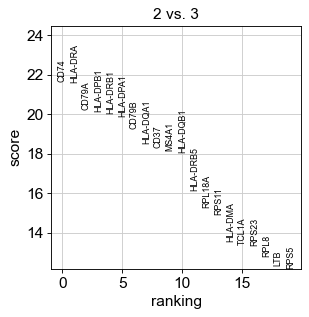

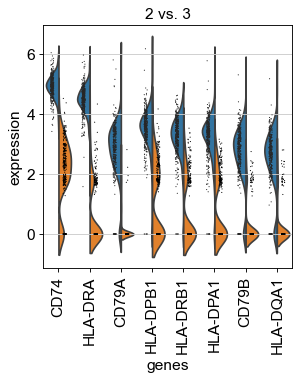

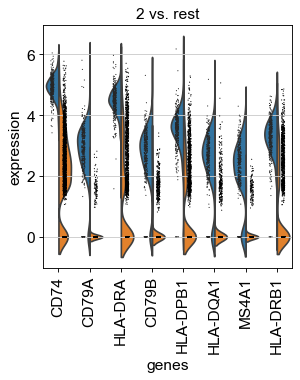

In [126]:
sc.settings.verbosity = 2
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14', 'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1', 'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']
pcHVG_data = sc.read(results_file)
pd.DataFrame(pcHVG_data.uns['rank_genes_groups']['names']).head(5)
result = pcHVG_data.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals']}).head(5)

sc.tl.rank_genes_groups(pcHVG_data, 'leiden', groups=['2'], reference='3', method='wilcoxon')
sc.pl.rank_genes_groups(pcHVG_data, groups=['2'], n_genes=20)

sc.pl.rank_genes_groups_violin(pcHVG_data, groups='2', n_genes=8)
pcHVG_data = sc.read(results_file)
sc.pl.rank_genes_groups_violin(pcHVG_data, groups='2', n_genes=8)

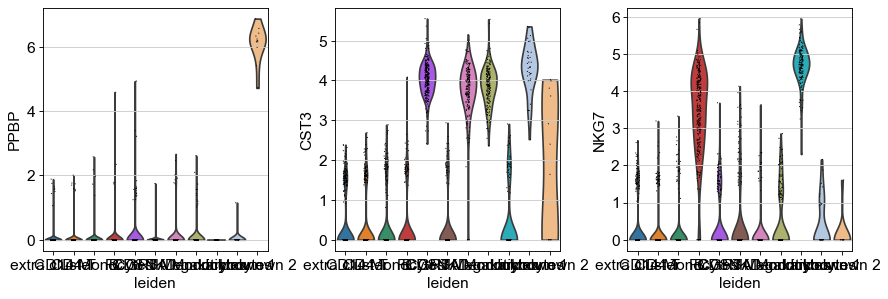

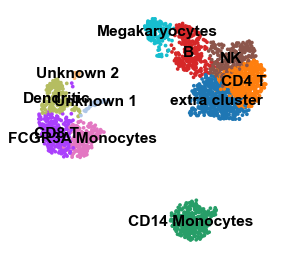

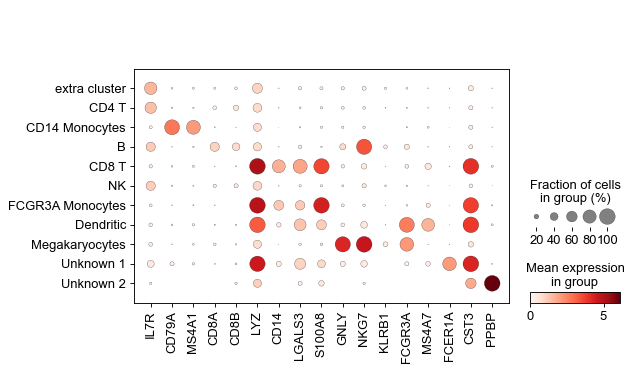

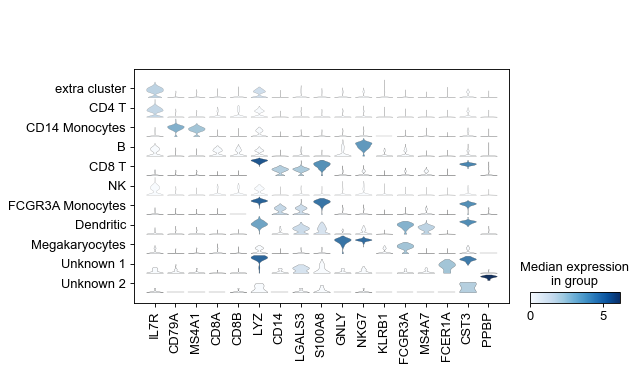

In [130]:
sc.pl.violin(pcHVG_data, ['PPBP', 'CST3', 'NKG7'], groupby='leiden')
new_cluster_names = ['extra cluster', 'CD4 T', 'CD14 Monocytes', 'B', 'CD8 T', 'NK', 'FCGR3A Monocytes', 'Dendritic', 'Megakaryocytes', 'Unknown 1', 'Unknown 2']
pcHVG_data.rename_categories('leiden', new_cluster_names)
sc.pl.umap(pcHVG_data, color='leiden', legend_loc='on data', title='', frameon=False)
sc.pl.dotplot(pcHVG_data, marker_genes, groupby='leiden')
sc.pl.stacked_violin(pcHVG_data, marker_genes, groupby='leiden', rotation=90)
pcHVG_data.write(results_file, compression='gzip')


In [142]:
from sklearn.metrics.cluster import adjusted_rand_score
import sys 
import os
import smtplib
import jgraph as ig